In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [6]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [8]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\lfmfi\AppData\Local\Temp\ipykernel_8528\3601434573.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [12]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [14]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Station = Base.classes.station
Measurement = Base.classes.measurement

In [16]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


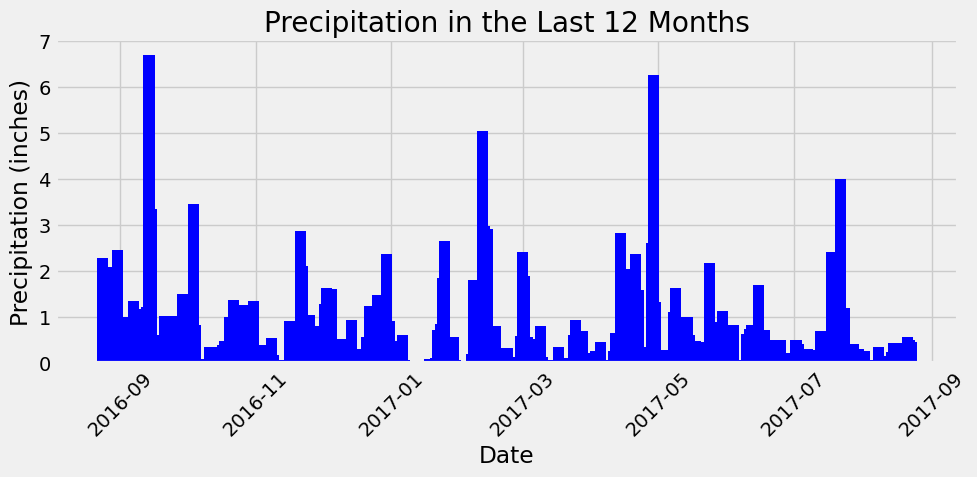

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
last_date = session.query(func.max(Measurement.date)).scalar()
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
one_year_ago = last_date - dt.timedelta(days=365) 

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
precipitation_df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
plt.bar(precipitation_df['date'], precipitation_df['precipitation'], color='blue', width=5)
plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Use Pandas to calculate the summary statistics for the precipitation data

# Calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['precipitation'].describe()

# Convert the summary statistics to a DataFrame
summary_statistics_df = summary_statistics.to_frame()

# Rename the columns for better readability
summary_statistics_df.columns = ['Precipitation (inches)']

summary_statistics_df

,Precipitation (inches)
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [37]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [39]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query to find the most active stations
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the results
for station, count in most_active_stations:
    print(f'Station: {station}, Count: {count}')

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = most_active_stations[0][0]

# Query to calculate the lowest, highest, and average temperatures for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

# Print the results
min_temp, max_temp, avg_temp = temperature_stats[0]
avg_temp_rounded = round(avg_temp, 1)

print(f'For station {most_active_station_id}:')
print(f'   Lowest Temperature: {min_temp}')
print(f'   Highest Temperature: {max_temp}')
print(f'   Average Temperature: {avg_temp_rounded}')

For station USC00519281:
   Lowest Temperature: 54.0
   Highest Temperature: 85.0
   Average Temperature: 71.7


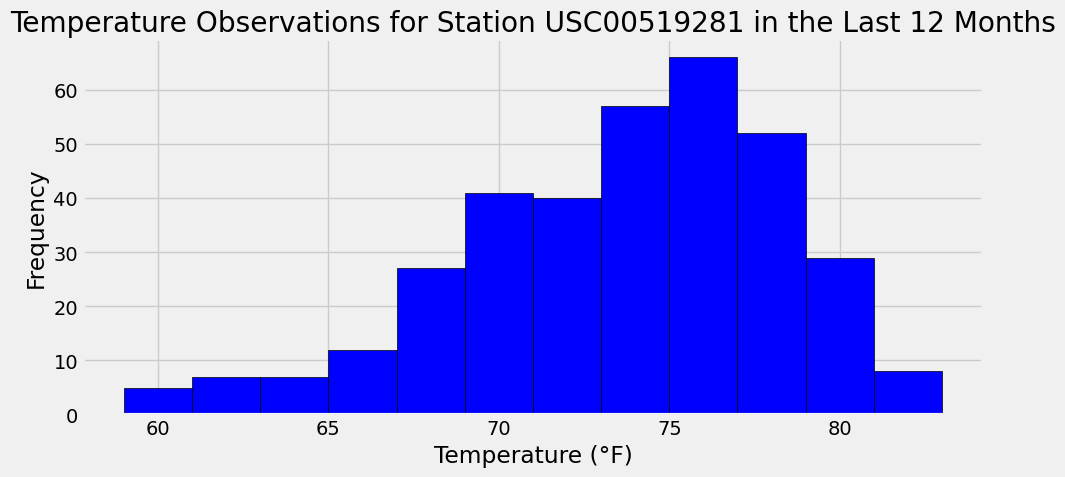

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date one year from the last date in the dataset
last_date = session.query(func.max(Measurement.date)).scalar()
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
one_year_ago = last_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=['tobs'])

# Plot the results as a histogram
plt.figure(figsize=(10, 5))
plt.hist(tobs_df['tobs'], bins=12, color='blue', edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station_id} in the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [51]:
# Close Session
session.close()